In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# Laad alle data
df = pd.read_csv('../data/processed/transactions_with_anomalies.csv')
df['Date'] = pd.to_datetime(df['Date'])

predictions = pd.read_csv('../data/processed/spending_predictions.csv')
anomalies = pd.read_csv('../data/processed/detected_anomalies.csv')

print("="*60)
print("DATA LOADED FOR FINAL VISUALIZATIONS")
print("="*60)
print(f"Transactions: {len(df)}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Categories: {df['Final_Category'].nunique()}")
print(f"Predictions: {len(predictions)} categories")
print(f"Anomalies: {len(anomalies)}")

DATA LOADED FOR FINAL VISUALIZATIONS
Transactions: 1505
Date range: 2024-12-08 to 2025-12-08
Categories: 23
Predictions: 10 categories
Anomalies: 76


CREATING EXECUTIVE SUMMARY DASHBOARD

✅ Executive dashboard saved: visualizations/09_executive_dashboard.png


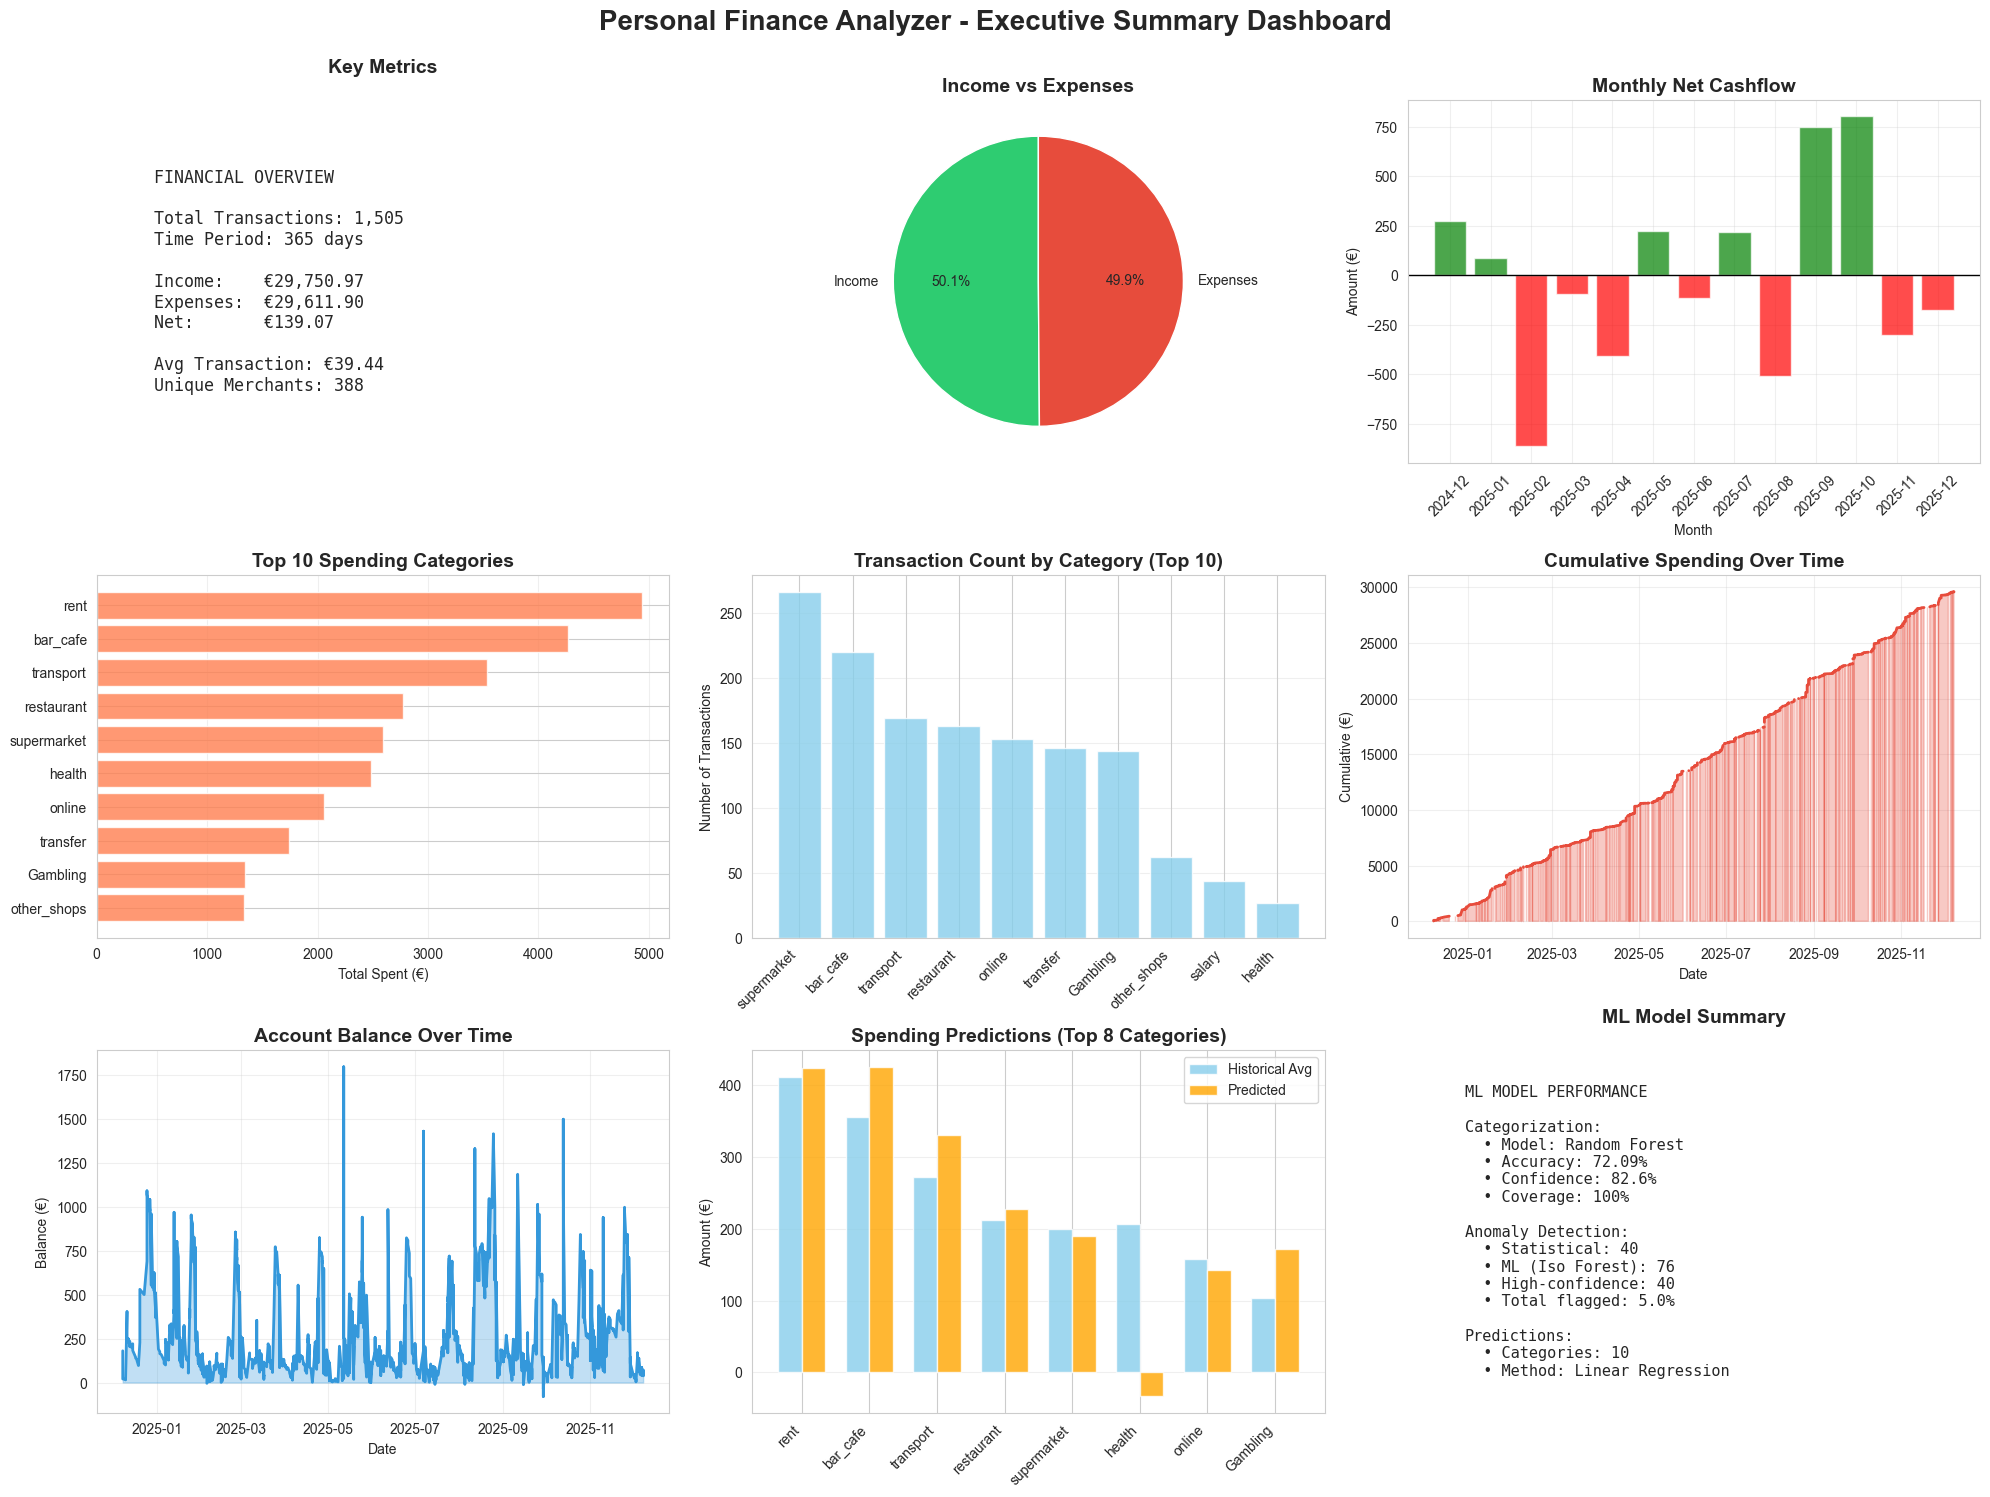

In [2]:
print("="*60)
print("CREATING EXECUTIVE SUMMARY DASHBOARD")
print("="*60)

# Calculate key metrics
total_transactions = len(df)
total_income = df[df['Amount'] > 0]['Amount'].sum()
total_expenses = df[df['Amount'] < 0]['Amount'].abs().sum()
net_cashflow = total_income - total_expenses
avg_transaction = df['Amount'].abs().mean()
unique_merchants = df['Counterparty'].nunique()
categorization_rate = 100  # We hebben 100% gecategoriseerd
anomaly_rate = (df['Is_Anomaly_Either'].sum() / len(df)) * 100

# Create summary dashboard
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Personal Finance Analyzer - Executive Summary Dashboard', 
             fontsize=20, fontweight='bold', y=0.995)

# 1. Key Metrics (Text boxes)
metrics_text = f"""
FINANCIAL OVERVIEW

Total Transactions: {total_transactions:,}
Time Period: {(df['Date'].max() - df['Date'].min()).days} days

Income:    €{total_income:,.2f}
Expenses:  €{total_expenses:,.2f}
Net:       €{net_cashflow:,.2f}

Avg Transaction: €{avg_transaction:.2f}
Unique Merchants: {unique_merchants}
"""

axes[0, 0].text(0.1, 0.5, metrics_text, fontsize=12, family='monospace',
                verticalalignment='center')
axes[0, 0].axis('off')
axes[0, 0].set_title('Key Metrics', fontsize=14, fontweight='bold', pad=20)

# 2. Income vs Expenses Pie
income_expense_data = [total_income, total_expenses]
colors_pie = ['#2ecc71', '#e74c3c']
axes[0, 1].pie(income_expense_data, labels=['Income', 'Expenses'], 
               autopct='%1.1f%%', colors=colors_pie, startangle=90)
axes[0, 1].set_title('Income vs Expenses', fontsize=14, fontweight='bold')

# 3. Monthly Net Cashflow
df_expenses_only = df[~df['Final_Category'].isin(['saving', 'transfer', 'atm'])].copy()
df_expenses_only['Year_Month'] = df_expenses_only['Date'].dt.to_period('M')
monthly_net = df_expenses_only.groupby('Year_Month')['Amount'].sum().reset_index()
monthly_net['Year_Month_Str'] = monthly_net['Year_Month'].astype(str)

axes[0, 2].bar(monthly_net['Year_Month_Str'], monthly_net['Amount'], 
               color=['green' if x > 0 else 'red' for x in monthly_net['Amount']], alpha=0.7)
axes[0, 2].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 2].set_title('Monthly Net Cashflow', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel('Amount (€)')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# 4. Top 10 Spending Categories
expenses_by_cat = df[df['Amount'] < 0].groupby('Final_Category')['Amount'].sum().abs().nlargest(10)
axes[1, 0].barh(range(len(expenses_by_cat)), expenses_by_cat.values, color='coral', alpha=0.8)
axes[1, 0].set_yticks(range(len(expenses_by_cat)))
axes[1, 0].set_yticklabels(expenses_by_cat.index)
axes[1, 0].invert_yaxis()
axes[1, 0].set_title('Top 10 Spending Categories', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Spent (€)')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 5. Category Distribution
cat_counts = df['Final_Category'].value_counts().head(10)
axes[1, 1].bar(range(len(cat_counts)), cat_counts.values, color='skyblue', alpha=0.8)
axes[1, 1].set_xticks(range(len(cat_counts)))
axes[1, 1].set_xticklabels(cat_counts.index, rotation=45, ha='right')
axes[1, 1].set_title('Transaction Count by Category (Top 10)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Spending Over Time (Cumulative)
df_sorted = df.sort_values('Date')
df_sorted['Cumulative_Spending'] = df_sorted[df_sorted['Amount'] < 0]['Amount'].abs().cumsum()
axes[1, 2].plot(df_sorted['Date'], df_sorted['Cumulative_Spending'], 
                linewidth=2, color='#e74c3c')
axes[1, 2].fill_between(df_sorted['Date'], df_sorted['Cumulative_Spending'], 
                         alpha=0.3, color='#e74c3c')
axes[1, 2].set_title('Cumulative Spending Over Time', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Cumulative (€)')
axes[1, 2].grid(True, alpha=0.3)

# 7. Balance Over Time
df_sorted['Balance_Clean'] = pd.to_numeric(df_sorted['Balance'], errors='coerce')
axes[2, 0].plot(df_sorted['Date'], df_sorted['Balance_Clean'], 
                linewidth=2, color='#3498db')
axes[2, 0].fill_between(df_sorted['Date'], df_sorted['Balance_Clean'], 
                         alpha=0.3, color='#3498db')
axes[2, 0].set_title('Account Balance Over Time', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Balance (€)')
axes[2, 0].grid(True, alpha=0.3)

# 8. Predictions vs Actual
pred_comparison = predictions[['Category', 'Predicted_Next_Month', 'Historical_Average']].head(8)
x_pred = range(len(pred_comparison))
width = 0.35
axes[2, 1].bar([i - width/2 for i in x_pred], pred_comparison['Historical_Average'], 
               width, label='Historical Avg', color='skyblue', alpha=0.8)
axes[2, 1].bar([i + width/2 for i in x_pred], pred_comparison['Predicted_Next_Month'], 
               width, label='Predicted', color='orange', alpha=0.8)
axes[2, 1].set_xticks(x_pred)
axes[2, 1].set_xticklabels(pred_comparison['Category'], rotation=45, ha='right')
axes[2, 1].set_title('Spending Predictions (Top 8 Categories)', fontsize=14, fontweight='bold')
axes[2, 1].set_ylabel('Amount (€)')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3, axis='y')

# 9. ML Performance Summary
ml_metrics_text = f"""
ML MODEL PERFORMANCE

Categorization:
  • Model: Random Forest
  • Accuracy: 72.09%
  • Confidence: 82.6%
  • Coverage: 100%

Anomaly Detection:
  • Statistical: {df['Is_Anomaly_Statistical'].sum()}
  • ML (Iso Forest): {df['Is_Anomaly_ML'].sum()}
  • High-confidence: {df['Is_Anomaly_Both'].sum()}
  • Total flagged: {anomaly_rate:.1f}%

Predictions:
  • Categories: {len(predictions)}
  • Method: Linear Regression
"""

axes[2, 2].text(0.1, 0.5, ml_metrics_text, fontsize=11, family='monospace',
                verticalalignment='center')
axes[2, 2].axis('off')
axes[2, 2].set_title('ML Model Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../visualizations/09_executive_dashboard.png', dpi=300, bbox_inches='tight')
print("\n✅ Executive dashboard saved: visualizations/09_executive_dashboard.png")
plt.show()

In [3]:
print("="*60)
print("CREATING INTERACTIVE PLOTLY VISUALIZATIONS")
print("="*60)

# 1. Interactive spending over time by category
df_expenses = df[~df['Final_Category'].isin(['saving', 'transfer', 'atm'])].copy()
df_expenses['Amount_Abs'] = df_expenses['Amount'].abs()

# Top 5 categories
top_5_cats = df_expenses.groupby('Final_Category')['Amount_Abs'].sum().nlargest(5).index

# Filter for top 5
df_top5 = df_expenses[df_expenses['Final_Category'].isin(top_5_cats)].copy()

# Create interactive line chart
fig1 = px.line(df_top5.groupby(['Date', 'Final_Category'])['Amount_Abs'].sum().reset_index(),
               x='Date', y='Amount_Abs', color='Final_Category',
               title='Daily Spending by Category (Top 5)',
               labels={'Amount_Abs': 'Amount (€)', 'Final_Category': 'Category'})

fig1.update_layout(hovermode='x unified', height=500)
fig1.write_html('../visualizations/interactive_spending_timeline.html')
print("✅ Interactive timeline saved: visualizations/interactive_spending_timeline.html")

# 2. Interactive scatter plot with anomalies
fig2 = go.Figure()

# Normal transactions
normal = df[df['Is_Anomaly_Either'] == 0]
fig2.add_trace(go.Scatter(
    x=normal['Date'],
    y=normal['Amount'].abs(),
    mode='markers',
    name='Normal',
    marker=dict(size=5, color='blue', opacity=0.5),
    text=normal['Counterparty'],
    hovertemplate='<b>%{text}</b><br>Date: %{x}<br>Amount: €%{y:.2f}<extra></extra>'
))

# Anomalies
anomaly = df[df['Is_Anomaly_Either'] == 1]
fig2.add_trace(go.Scatter(
    x=anomaly['Date'],
    y=anomaly['Amount'].abs(),
    mode='markers',
    name='Anomaly',
    marker=dict(size=12, color='red', symbol='x'),
    text=anomaly['Counterparty'],
    hovertemplate='<b>⚠️ ANOMALY</b><br>%{text}<br>Date: %{x}<br>Amount: €%{y:.2f}<extra></extra>'
))

fig2.update_layout(
    title='Transaction Anomalies Over Time (Interactive)',
    xaxis_title='Date',
    yaxis_title='Amount (€)',
    hovermode='closest',
    height=500
)

fig2.write_html('../visualizations/interactive_anomalies.html')
print("✅ Interactive anomalies saved: visualizations/interactive_anomalies.html")

# 3. Interactive category breakdown (Sunburst)
category_breakdown = df_expenses.groupby('Final_Category')['Amount_Abs'].sum().reset_index()
category_breakdown.columns = ['Category', 'Total']

fig3 = px.sunburst(
    category_breakdown,
    path=['Category'],
    values='Total',
    title='Spending Distribution by Category (Interactive Sunburst)',
    color='Total',
    color_continuous_scale='RdYlGn_r'
)

fig3.update_layout(height=600)
fig3.write_html('../visualizations/interactive_category_sunburst.html')
print("✅ Interactive sunburst saved: visualizations/interactive_category_sunburst.html")

print("\n💡 Tip: Open the .html files in your browser to interact with the charts!")

CREATING INTERACTIVE PLOTLY VISUALIZATIONS
✅ Interactive timeline saved: visualizations/interactive_spending_timeline.html
✅ Interactive anomalies saved: visualizations/interactive_anomalies.html
✅ Interactive sunburst saved: visualizations/interactive_category_sunburst.html

💡 Tip: Open the .html files in your browser to interact with the charts!


CREATING TIME-BASED ANALYSIS VISUALIZATIONS

✅ Time analysis saved: visualizations/10_time_analysis.png


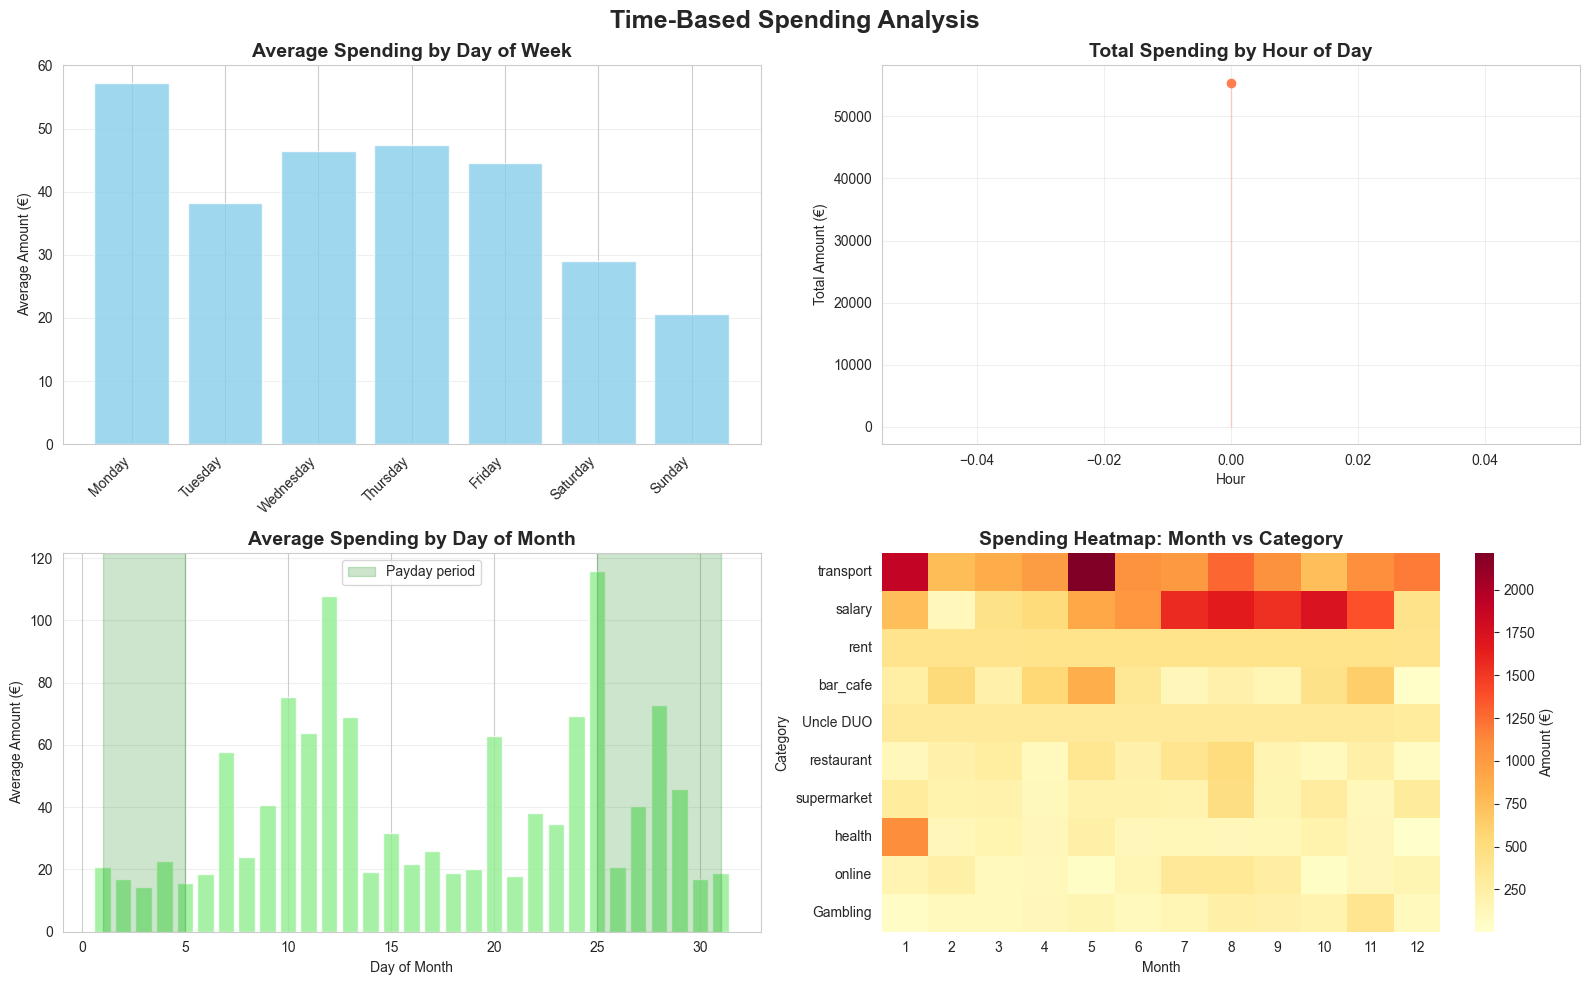

In [4]:
print("="*60)
print("CREATING TIME-BASED ANALYSIS VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Time-Based Spending Analysis', fontsize=18, fontweight='bold')

# 1. Spending by Day of Week
df_expenses['DayOfWeek'] = df_expenses['Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_spending = df_expenses.groupby('DayOfWeek')['Amount_Abs'].mean().reindex(day_order)

axes[0, 0].bar(range(7), day_spending.values, color='skyblue', alpha=0.8)
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(day_order, rotation=45, ha='right')
axes[0, 0].set_title('Average Spending by Day of Week', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Average Amount (€)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Spending by Hour (if available)
if 'Hour' in df_expenses.columns:
    hour_spending = df_expenses.groupby('Hour')['Amount_Abs'].sum()
    axes[0, 1].plot(hour_spending.index, hour_spending.values, marker='o', linewidth=2, color='coral')
    axes[0, 1].fill_between(hour_spending.index, hour_spending.values, alpha=0.3, color='coral')
    axes[0, 1].set_title('Total Spending by Hour of Day', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('Total Amount (€)')
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'Hour data not available', ha='center', va='center', fontsize=12)
    axes[0, 1].axis('off')

# 3. Spending by Day of Month
df_expenses['DayOfMonth'] = df_expenses['Date'].dt.day
day_of_month_spending = df_expenses.groupby('DayOfMonth')['Amount_Abs'].mean()

axes[1, 0].bar(day_of_month_spending.index, day_of_month_spending.values, color='lightgreen', alpha=0.8)
axes[1, 0].set_title('Average Spending by Day of Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Month')
axes[1, 0].set_ylabel('Average Amount (€)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Highlight payday patterns (typically around 25th-1st)
axes[1, 0].axvspan(25, 31, alpha=0.2, color='green', label='Payday period')
axes[1, 0].axvspan(1, 5, alpha=0.2, color='green')
axes[1, 0].legend()

# 4. Heatmap: Month vs Category
df_expenses['Month'] = df_expenses['Date'].dt.month
pivot_data = df_expenses.groupby(['Month', 'Final_Category'])['Amount_Abs'].sum().unstack(fill_value=0)

# Only top 10 categories
top_cats = df_expenses.groupby('Final_Category')['Amount_Abs'].sum().nlargest(10).index
pivot_data_top = pivot_data[top_cats]

sns.heatmap(pivot_data_top.T, annot=False, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Amount (€)'}, ax=axes[1, 1])
axes[1, 1].set_title('Spending Heatmap: Month vs Category', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Category')

plt.tight_layout()
plt.savefig('../visualizations/10_time_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Time analysis saved: visualizations/10_time_analysis.png")
plt.show()

CREATING MERCHANT ANALYSIS

✅ Merchant analysis saved: visualizations/11_merchant_analysis.png


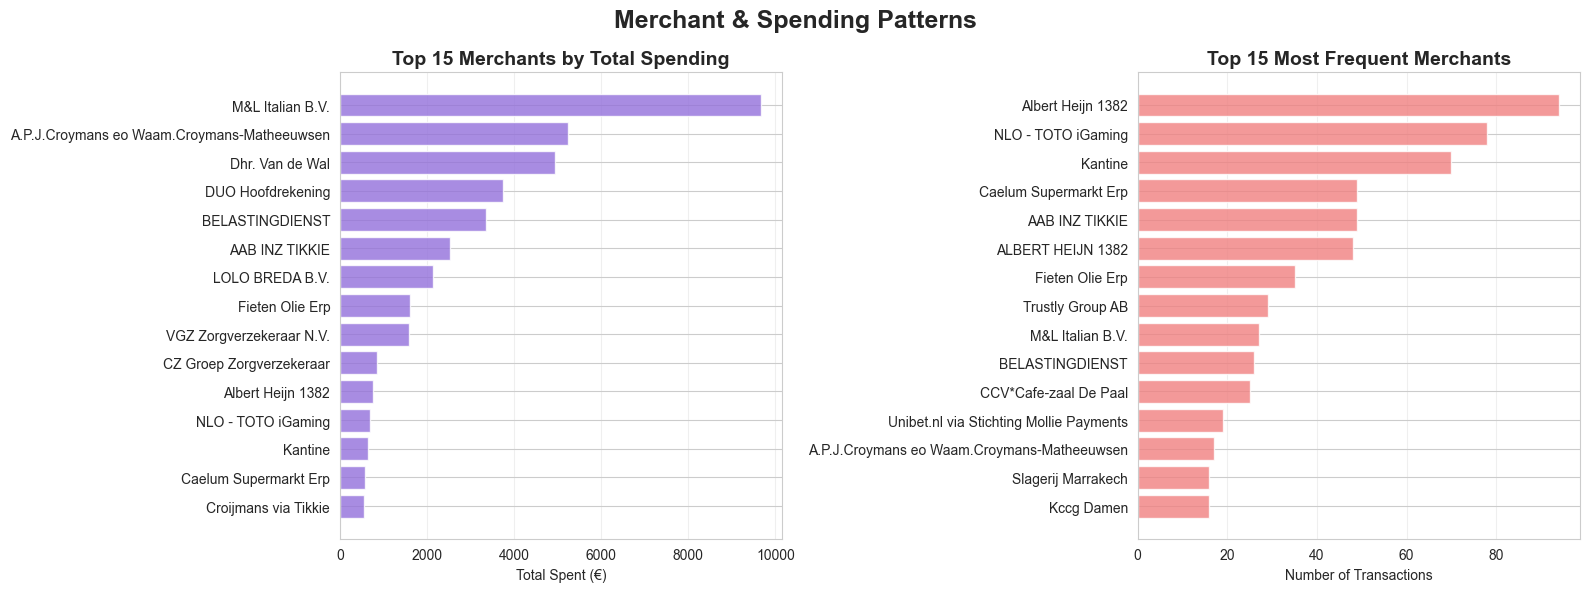

In [5]:
print("="*60)
print("CREATING MERCHANT ANALYSIS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Merchant & Spending Patterns', fontsize=18, fontweight='bold')

# 1. Top 15 Merchants by spending
merchant_spending = df_expenses.groupby('Counterparty')['Amount_Abs'].sum().nlargest(15)
axes[0].barh(range(len(merchant_spending)), merchant_spending.values, color='mediumpurple', alpha=0.8)
axes[0].set_yticks(range(len(merchant_spending)))
axes[0].set_yticklabels(merchant_spending.index)
axes[0].invert_yaxis()
axes[0].set_title('Top 15 Merchants by Total Spending', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Spent (€)')
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Top 15 Merchants by frequency
merchant_frequency = df_expenses['Counterparty'].value_counts().head(15)
axes[1].barh(range(len(merchant_frequency)), merchant_frequency.values, color='lightcoral', alpha=0.8)
axes[1].set_yticks(range(len(merchant_frequency)))
axes[1].set_yticklabels(merchant_frequency.index)
axes[1].invert_yaxis()
axes[1].set_title('Top 15 Most Frequent Merchants', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Transactions')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../visualizations/11_merchant_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Merchant analysis saved: visualizations/11_merchant_analysis.png")
plt.show()

In [6]:
print("="*60)
print("GENERATING FINAL STATISTICS REPORT")
print("="*60)

# Create comprehensive statistics report
report = f"""
{'='*70}
               PERSONAL FINANCE ANALYZER
                 FINAL STATISTICS REPORT
{'='*70}

DATA OVERVIEW
{'-'*70}
Total Transactions:        {len(df):,}
Date Range:                {df['Date'].min().date()} to {df['Date'].max().date()}
Days Covered:              {(df['Date'].max() - df['Date'].min()).days}
Unique Merchants:          {df['Counterparty'].nunique():,}

FINANCIAL SUMMARY
{'-'*70}
Total Income:              €{total_income:,.2f}
Total Expenses:            €{total_expenses:,.2f}
Net Cashflow:              €{net_cashflow:,.2f}

Average Transaction:       €{avg_transaction:.2f}
Median Transaction:        €{df['Amount'].abs().median():.2f}
Largest Expense:           €{df[df['Amount'] < 0]['Amount'].min():.2f}
Largest Income:            €{df[df['Amount'] > 0]['Amount'].max():.2f}

CATEGORIZATION
{'-'*70}
Total Categories:          {df['Final_Category'].nunique()}
Categorization Rate:       100%
ML Model Accuracy:         72.09%
Prediction Confidence:     82.6%

Top 5 Spending Categories:
"""

top_5_spending = df[df['Amount'] < 0].groupby('Final_Category')['Amount'].sum().abs().nlargest(5)
for i, (cat, amount) in enumerate(top_5_spending.items(), 1):
    report += f"  {i}. {cat.ljust(20)} €{amount:,.2f}\n"

report += f"""
ANOMALY DETECTION
{'-'*70}
Total Anomalies Detected:  {df['Is_Anomaly_Either'].sum()} ({anomaly_rate:.1f}%)
Statistical Method:        {df['Is_Anomaly_Statistical'].sum()}
ML Method (Iso Forest):    {df['Is_Anomaly_ML'].sum()}
High-Confidence:           {df['Is_Anomaly_Both'].sum()}

SPENDING PREDICTIONS
{'-'*70}
Categories Predicted:      {len(predictions)}
Predicted Next Month:      €{predictions['Predicted_Next_Month'].sum():,.2f}
Historical Average:        €{predictions['Historical_Average'].mean():,.2f}

TIME PATTERNS
{'-'*70}
Most Expensive Day:        {day_spending.idxmax()} (€{day_spending.max():.2f} avg)
Cheapest Day:              {day_spending.idxmin()} (€{day_spending.min():.2f} avg)
Weekend vs Weekday:        {(df_expenses[df_expenses['Date'].dt.dayofweek >= 5]['Amount_Abs'].sum() / df_expenses[df_expenses['Date'].dt.dayofweek < 5]['Amount_Abs'].sum() * 100):.1f}% of weekday spending

TOP MERCHANTS
{'-'*70}
By Spending:
"""

for i, (merchant, amount) in enumerate(merchant_spending.head(5).items(), 1):
    report += f"  {i}. {merchant[:30].ljust(30)} €{amount:,.2f}\n"

report += f"""
By Frequency:
"""

for i, (merchant, count) in enumerate(merchant_frequency.head(5).items(), 1):
    report += f"  {i}. {merchant[:30].ljust(30)} {count} transactions\n"

report += f"""
{'='*70}
                      END OF REPORT
{'='*70}
"""

# Save report
with open('../docs/statistics_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)
print("\n✅ Statistics report saved: docs/statistics_report.txt")

print("\n" + "="*60)
print("📊 STEP 8 SUMMARY")
print("="*60)
print("✅ Executive dashboard created (9 panels)")
print("✅ Interactive visualizations (3 HTML files)")
print("✅ Time-based analysis")
print("✅ Merchant analysis")
print("✅ Comprehensive statistics report")

print("\n🎉 STEP 8 COMPLETE!")
print("\nAll Python analysis is now finished!")
print("Next: Power BI Dashboard (Step 9-10)")

GENERATING FINAL STATISTICS REPORT

               PERSONAL FINANCE ANALYZER
                 FINAL STATISTICS REPORT

DATA OVERVIEW
----------------------------------------------------------------------
Total Transactions:        1,505
Date Range:                2024-12-08 to 2025-12-08
Days Covered:              365
Unique Merchants:          388

FINANCIAL SUMMARY
----------------------------------------------------------------------
Total Income:              €29,750.97
Total Expenses:            €29,611.90
Net Cashflow:              €139.07

Average Transaction:       €39.44
Median Transaction:        €12.21
Largest Expense:           €-552.06
Largest Income:            €1366.05

CATEGORIZATION
----------------------------------------------------------------------
Total Categories:          23
Categorization Rate:       100%
ML Model Accuracy:         72.09%
Prediction Confidence:     82.6%

Top 5 Spending Categories:
  1. rent                 €4,936.00
  2. bar_cafe             €